# Clustering: Gamma Ray Bursts

## WIP - Unfinished!!!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import sklearn
from sklearn.cluster import (KMeans, MeanShift, estimate_bandwidth)
from sklearn import preprocessing

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 12

# File fetch and read

## Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)


In [ ]:
# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [3]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [4]:
data.T

array([['GRB230514A*', 'GRB230514996', '23:54:16.152', ..., '5.8880',
        'True', '60078.99602028'],
       ['GRB230513A*', 'GRB230513929', '22:17:18.149', ..., '4.8000',
        'True', '60077.92868228'],
       ['GRB230512A*', 'GRB230512269', '6:27:45.413', ..., '2.6240',
        'True', '60076.26927561'],
       ...,
       ['GRB910424A*', 'None', '19:43:25.064', ..., '3.1360', 'False',
        '48370.82181787'],
       ['GRB910423A*', 'None', '19:51:15.804', ..., '208.5760', 'False',
        '48369.82726625'],
       ['GRB910421A*', 'None', '9:14:03.800', ..., '5.6960', 'False',
        '48367.38476620']], dtype='<U14')

## T90 vs Flux

In [5]:
#Column splicing

#They're read as strings!!! Converting is mandatory
T90 = np.array(data[6, :], dtype=float)
flux = np.array(data[9, :], dtype=float)



In [6]:
#Filtering good data
filter = (T90 > 0) & (flux > 0)     #Mask 

T90clean = T90[filter]
flux_clean = flux[filter]

[]

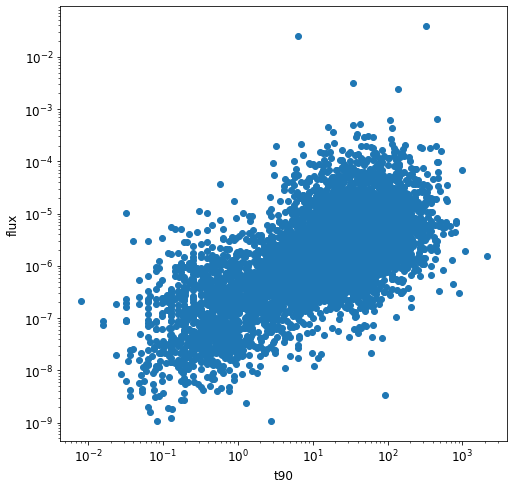

In [7]:
plt.scatter(T90clean, flux_clean)
plt.xlabel('t90')
plt.ylabel('flux')
plt.loglog()

### K-means clustering with 2 n_clusters

In [8]:
#Reshaping, sklearn is picky!!

print(T90clean.shape)
print(flux_clean.shape)

new_T90clean = T90clean[:, np.newaxis]
new_flux_clean = flux_clean[:, np.newaxis]

print(new_T90clean.shape)
print(new_flux_clean.shape)

#Constructing the dataset, formatted as sklearn input (rows[n_samples] x columns[1])
to_fit = np.column_stack([new_T90clean, new_flux_clean])
to_fit.shape


(6995,)
(6995,)
(6995, 1)
(6995, 1)


(6995, 2)

In [9]:
#KMeans Cluster initialization
cluster = KMeans(n_clusters=2)

#Since I then plot in loglog, I transform input data in loglog form

to_fit = np.log(to_fit)
to_fit.shape


(6995, 2)

In [10]:

#Training the model
cluster.fit(to_fit)

#Clusters positions
centers = cluster.cluster_centers_

#Labels characterizing each cluster
labels = cluster.predict(to_fit)

print(centers.shape)
print(labels.shape)

(2, 2)
(6995,)


Text(0.5, 1.0, 'Clustering output')

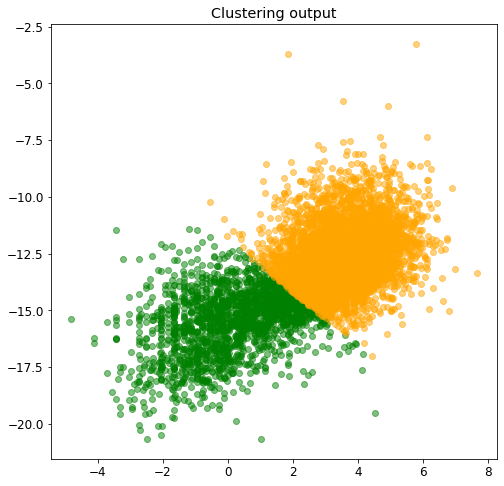

In [11]:
# plot the data color-coded by cluster id

colors = ['green', 'orange']
for i in range(2):
    plt.scatter(x=to_fit[labels==i,0], y=to_fit[labels==i,1], 
                color=colors[i],alpha=0.5)


#Because of the way in which I trained the cluster, the plot is already in loglog
#plt.loglog()

plt.title('Clustering output')

### K-means clustering with 4 n_clusters

In [12]:
#Reshaping, sklearn is picky!!

print(T90clean.shape)
print(flux_clean.shape)

new_T90clean = T90clean[:, np.newaxis]
new_flux_clean = flux_clean[:, np.newaxis]

print(new_T90clean.shape)
print(new_flux_clean.shape)

#Constructing the dataset, formatted as sklearn input (rows[n_samples] x columns[1])
to_fit = np.column_stack([new_T90clean, new_flux_clean])
to_fit.shape


(6995,)
(6995,)
(6995, 1)
(6995, 1)


(6995, 2)

In [13]:
#KMeans Cluster initialization
cluster = KMeans(n_clusters=4)

#Since I then plot in loglog, I transform input data in loglog form

to_fit = np.log(to_fit)
to_fit.shape


(6995, 2)

In [14]:

#Training the model
cluster.fit(to_fit)

#Clusters positions
centers = cluster.cluster_centers_

#Labels characterizing each cluster
labels = cluster.predict(to_fit)

print(centers.shape)
print(labels.shape)

(4, 2)
(6995,)


Text(0.5, 1.0, 'Clustering output')

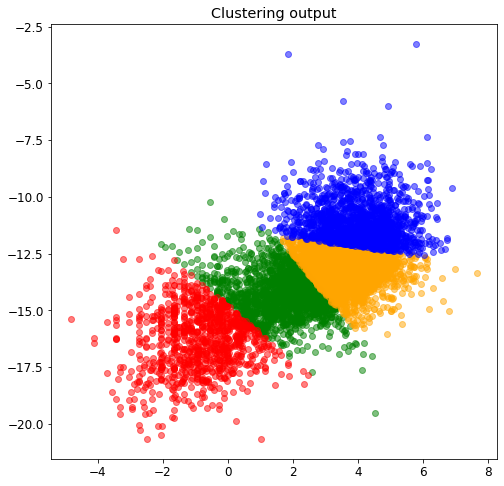

In [15]:
# plot the data color-coded by cluster id

colors = ['green', 'orange', 'red', 'blue']
for i in range(4):
    plt.scatter(x=to_fit[labels==i,0], y=to_fit[labels==i,1], 
                color=colors[i],alpha=0.5)


#Because of the way in which I trained the cluster, the plot is already in loglog
#plt.loglog()

plt.title('Clustering output')

### Mean-Shift Clustering

In [16]:
# Compute the Mean-shift clustering


scaler = preprocessing.StandardScaler()

#Manually setting the bandwitdh
#bandwidth = 1

#Exploiting implemented technique to estimate best bandwith, for large dataset is slow!
bandwidth = estimate_bandwidth(to_fit)

ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=True, 
               cluster_all=True)
ms.fit(to_fit)
#ms.fit(scaler.fit_transform(to_fit))

labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])

print(labels_unique)
print('Bandwidth: ', bandwidth)
print("number of estimated clusters :", n_clusters)

[0 1 2]
Bandwidth:  2.1168911622173385
number of estimated clusters : 3


## Right Ascension vs Declination

In [17]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [18]:
ra = np.array(data[3, :], dtype=float)
dec = np.array(data[4, :], dtype=float)


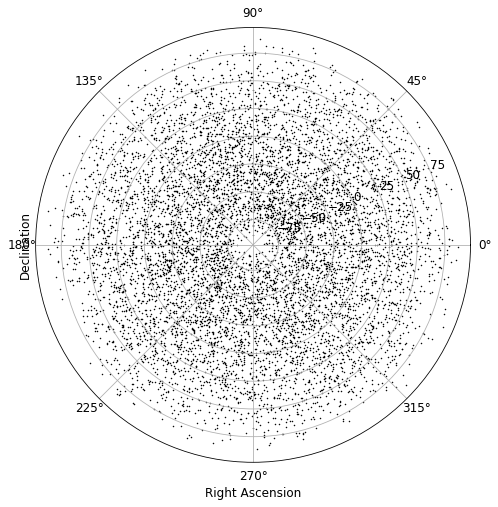

In [19]:
#Polar Plot
ax = plt.subplot(polar=True)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

'''
#Ticks position
angs = np.array([330., 345., 0., 15., 30., 45., 60., 75., 90., 105., 120.])
plt.xticks(angs * np.pi / 180., fontsize=8, c='red')
plt.yticks(np.arange(-80, -59, 10), fontsize=8, c='red')
ax.set_rlabel_position(120)
ax.set_xticklabels(['$22^h$', '$23^h$', '$0^h$', '$1^h$', '$2^h$', '$3^h$',
    '$4^h$', '$5^h$', '$6^h$', '$7^h$', '$8^h$'], fontsize=10)
ax.set_yticklabels(['$-80^{\circ}$', '$-70^{\circ}$', '$-60^{\circ}$'],
    fontsize=10, c='red')
'''


#Scatter points
ax.scatter(ra, dec, marker='o', c='k', s=1, lw=0.5)
plt.show()

(array([[   0.,   21., 1057.,  949., 1026., 1011., 1037., 1015., 1024.,
          996.],
        [1343., 2738., 2754., 1301.,    0.,    0.,    0.,    0.,    0.,
            0.]]),
 array([-89.0086 , -44.12274,   0.76312,  45.64898,  90.53484, 135.4207 ,
        180.30656, 225.19242, 270.07828, 314.96414, 359.85   ]),
 <a list of 2 BarContainer objects>)

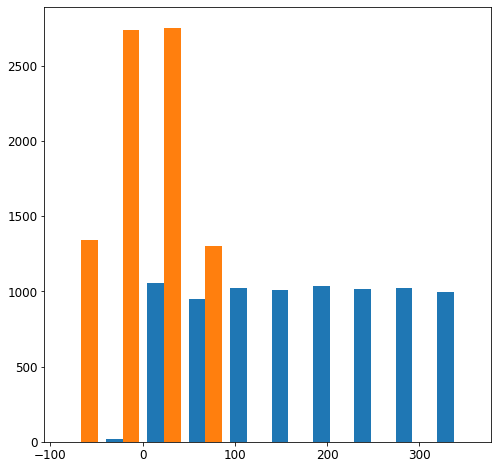

In [20]:
plt.hist([ra, dec])

In [21]:
to_fit = np.column_stack([ra, dec])

In [22]:
#Since there are no clear number of clusters -> Trying with the Mean-shift clustering


scaler = preprocessing.StandardScaler()

#Manually setting the bandwitdh
#bandwidth = 1

#Exploiting implemented technique to estimate best bandwith, for large dataset is slow!
bandwidth = estimate_bandwidth(to_fit)

ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=True, 
               cluster_all=True)
#ms.fit(to_fit)
ms.fit(scaler.fit_transform(to_fit))

labels_unique = np.unique(ms.labels_)
ra_dec_clusters = len(labels_unique[labels_unique >= 0])

print(labels_unique)
print('Bandwidth: ', bandwidth)
print("number of estimated clusters :", ra_dec_clusters)


[0]
Bandwidth:  87.40627198251482
number of estimated clusters : 1


In [23]:
ra_dec_clusters

1

In [24]:
cluster = KMeans(n_clusters=ra_dec_clusters)

#Training the model
cluster.fit(to_fit)

#Clusters positions
centers = cluster.cluster_centers_

#Labels characterizing each cluster
labels = cluster.predict(to_fit)

print(centers.shape)
print(labels.shape)

(1, 2)
(8136,)


Text(0.5, 1.0, 'Clustering output')

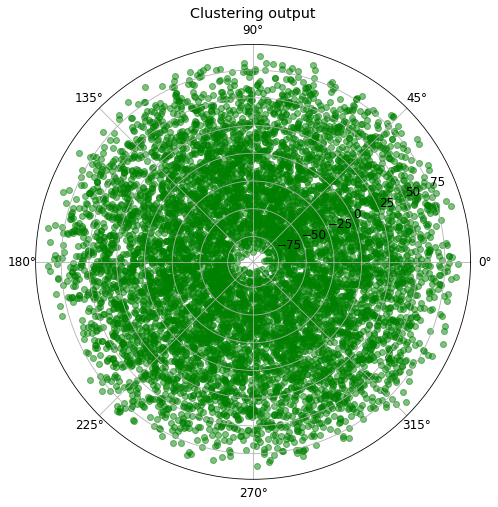

In [25]:
# plot the data color-coded by cluster id

ax = plt.subplot(polar=True)


colors = ['green', 'orange', 'red', 'blue']
for i in range(2):
    ax.scatter(x=to_fit[labels==i,0], y=to_fit[labels==i,1], 
                color=colors[i],alpha=0.5)


#Because of the way in which I trained the cluster, the plot is already in loglog
#plt.loglog()

plt.title('Clustering output')

There is no clear separation between clusters, this analysis is leading nowhere (good sign?).

## 

In [26]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [27]:
redshift = np.array(data[11, :], dtype=float)

In [28]:
redshift.shape


(8136,)

In [29]:

red_flux_mask = ((redshift >= 0) & (flux >= 0))

In [30]:
redshift_clean = redshift[red_flux_mask]
flux_clean = flux[red_flux_mask]


In [31]:
redshift_clean

array([9.0000e-02, 1.6640e+00, 6.5000e-02, 4.8400e-01, 2.1420e+00,
       3.8100e+00, 2.6940e+00, 4.0600e+00, 1.5100e-01, 3.0840e+00,
       1.2049e+00, 8.5700e-01, 5.6000e+00, 5.3000e-01, 4.9610e+00,
       1.2460e+00, 4.6180e+00, 2.2800e-01, 1.0800e-01, 2.2720e+00,
       1.1137e+00, 6.6070e-01, 3.9000e-01, 6.4000e-01, 2.4110e-01,
       5.0000e-02, 1.7360e+00, 1.2525e+00, 3.5000e-01, 1.1450e+00,
       1.2700e+00, 1.9370e+00, 1.1300e+00, 3.5400e+00, 3.5400e+00,
       2.4860e+00, 2.2100e-01, 2.0770e+00, 1.4000e+00, 2.8260e+00,
       4.2000e-01, 1.4870e+00, 2.1980e+00, 7.1500e-01, 1.1710e+00,
       2.0000e+00, 9.2000e-01, 1.0460e+00, 5.7000e+00, 1.1000e+00,
       1.1050e+00, 1.9540e+00, 9.9900e-01, 1.0700e+00, 8.0400e-01,
       2.9030e+00, 4.2600e-01, 4.5600e+00, 1.2500e+00, 7.4810e-01,
       7.3000e-01, 1.2268e+00, 1.2560e+00, 1.1480e+00, 2.4800e-01,
       1.7220e+00, 3.5030e+00, 7.8500e-02, 2.4690e+00, 1.9420e+00,
       1.1715e+00, 4.2000e-01, 3.3765e+00, 1.8590e+00, 2.4000e

In [32]:
flux_clean

array([9.1265e-06, 1.3000e-06, 3.1475e-03, 1.6000e-07, 7.1478e-05,
       8.1200e-07, 1.1402e-06, 5.1000e-07, 3.8836e-02, 4.5358e-05,
       6.7000e-07, 5.1774e-05, 9.1851e-07, 1.5550e-07, 1.6000e-06,
       1.8004e-05, 6.0375e-05, 8.0000e-06, 5.0118e-04, 1.9000e-07,
       6.8000e-06, 1.7000e-07, 9.3256e-05, 1.5335e-04, 8.8000e-08,
       1.2052e-05, 2.0000e-05, 3.0532e-06, 4.5000e-08, 4.3665e-06,
       4.0022e-05, 3.0248e-04, 1.1042e-04, 1.2845e-06, 7.3090e-07,
       1.5000e-07, 2.3152e-07, 2.7000e-06, 1.5000e-06, 1.2000e-06,
       1.0922e-06, 6.7000e-07, 3.4000e-07, 9.8000e-07, 7.5698e-05,
       2.3300e-05, 1.9137e-05, 6.3567e-07, 1.8000e-06, 1.3632e-04,
       2.4556e-06, 1.8000e-06, 8.1000e-07, 1.6782e-06, 3.4131e-05,
       1.5622e-06, 2.0000e-07, 3.1000e-07, 2.1351e-04, 4.2645e-06,
       1.8648e-06, 4.8873e-05, 1.3964e-05, 1.9000e-05, 1.0000e-05,
       8.5225e-07, 2.5000e-06, 1.5434e-05, 7.1179e-06, 9.9000e-08,
       1.6380e-05, 4.4325e-04, 8.0000e-07, 6.0000e-06, 1.5000e

[]

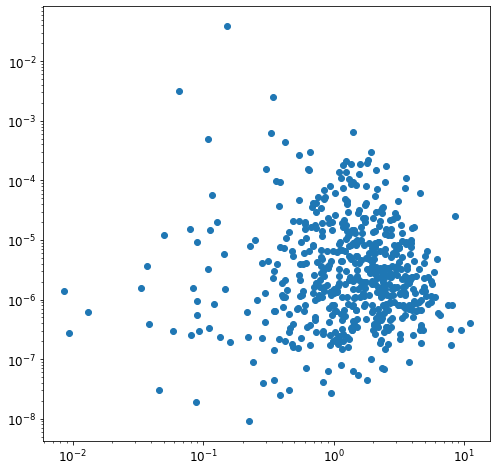

In [33]:
plt.scatter(redshift_clean, flux_clean)
plt.loglog()

In [34]:
np.min(redshift_clean)

0.0085

In [35]:
to_fit = np.column_stack([np.log(redshift_clean), np.log(flux_clean)])

In [36]:
# Compute the Mean-shift clustering


scaler = preprocessing.StandardScaler()

#Manually setting the bandwitdh
#bandwidth = 1

#Exploiting implemented technique to estimate best bandwith, for large dataset is slow!
bandwidth = estimate_bandwidth(to_fit)

ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=True, 
               cluster_all=True)
#ms.fit(to_fit)
ms.fit(scaler.fit_transform(to_fit))

labels_unique = np.unique(ms.labels_)
redflux_clusters = len(labels_unique[labels_unique >= 0])

print(labels_unique)
print('Bandwidth: ', bandwidth)
print("number of estimated clusters :", redflux_clusters)

[0]
Bandwidth:  1.8013519607226514
number of estimated clusters : 1


In [37]:
cluster = KMeans(n_clusters=redflux_clusters)

#Training the model
cluster.fit(to_fit)

#Clusters positions
centers = cluster.cluster_centers_

#Labels characterizing each cluster
labels = cluster.predict(to_fit)

print(centers.shape)
print(labels.shape)

(1, 2)
(565,)


Text(0.5, 1.0, 'Clustering output')

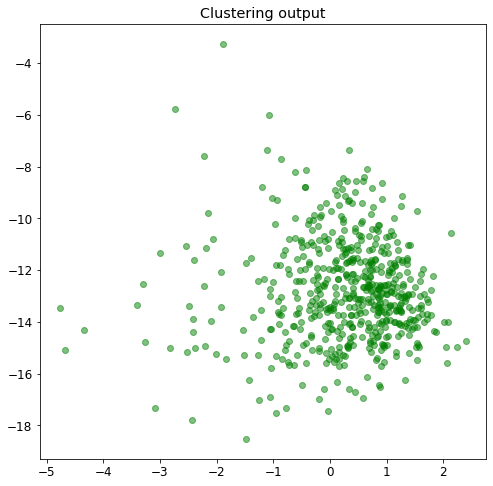

In [38]:
# plot the data color-coded by cluster id

ax = plt.subplot()


colors = ['green', 'orange', 'red', 'blue']
for i in range(3):
    ax.scatter(x=to_fit[labels==i,0], y=to_fit[labels==i,1], 
                color=colors[i],alpha=0.5)


#Because of the way in which I trained the cluster, the plot is already in loglog
#plt.loglog()

plt.title('Clustering output')

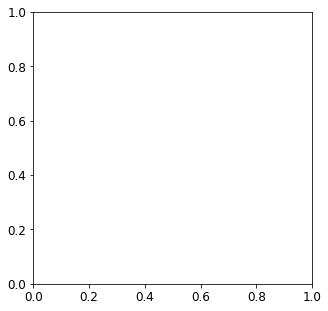

In [39]:
# Project onto 2 axes with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # 2 components
pca.fit(to_fit) # Do the fitting

X_reduced = to_fit.copy()

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()




In [40]:
X_reduced[:, 0]

array([-2.40794561e+00,  5.09224342e-01, -2.73336801e+00, -7.25670372e-01,
        7.61739972e-01,  1.33762919e+00,  9.91027078e-01,  1.40118297e+00,
       -1.89047544e+00,  1.12622746e+00,  1.86396576e-01, -1.54317360e-01,
        1.72276660e+00, -6.34878272e-01,  1.60160733e+00,  2.19938420e-01,
        1.52996171e+00, -1.47840965e+00, -2.22562405e+00,  8.20660501e-01,
        1.07687805e-01, -4.14455400e-01, -9.41608540e-01, -4.46287103e-01,
       -1.42254349e+00, -2.99573227e+00,  5.51583616e-01,  2.25141554e-01,
       -1.04982212e+00,  1.35404637e-01,  2.39016900e-01,  6.61140384e-01,
        1.22217633e-01,  1.26412673e+00,  1.26412673e+00,  9.10674993e-01,
       -1.50959258e+00,  7.30924545e-01,  3.36472237e-01,  1.03886228e+00,
       -8.67500568e-01,  3.96760667e-01,  7.87547856e-01, -3.35472736e-01,
        1.57858085e-01,  6.93147181e-01, -8.33816089e-02,  4.49733656e-02,
        1.74046617e+00,  9.53101798e-02,  9.98453350e-02,  6.69878554e-01,
       -1.00050033e-03,  

In [41]:

X_reduced[:, 1]

array([-11.60432829, -13.55314629,  -5.76114679, -15.64809202,
        -9.54612085, -14.0237655 , -13.68430687, -14.48885511,
        -3.24840763, -10.00092399, -14.21598812,  -9.86862247,
       -13.90051305, -15.67662011, -13.34550693, -10.9249166 ,
        -9.71493545, -11.73606902,  -7.59854524, -15.47624176,
       -11.89858795, -15.5874674 ,  -9.28016216,  -8.78278767,
       -16.24592902, -11.32627994, -10.81977828, -12.69932034,
       -16.91660335, -12.34154879, -10.12608126,  -8.1034954 ,
        -9.11121928, -13.56514102, -14.12898919, -15.71263054,
       -15.27859957, -12.82225878, -13.41004545, -13.633189  ,
       -13.72731655, -14.21598812, -14.89432022, -13.83571327,
        -9.48875882, -10.6670572 , -10.86388692, -14.26858628,
       -13.22772389,  -8.90050549, -12.91713943, -13.22772389,
       -14.02623159, -13.29778877, -10.2853045 , -13.36941547,
       -15.42494847, -14.98669354,  -8.45182689, -12.36518562,
       -13.19235675,  -9.92628546, -11.17902797, -10.87

Text(0, 0.5, 'Eigenvalue 2')

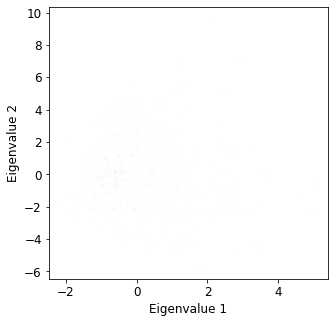

In [42]:
# Project onto 2 axes with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # 2 components
pca.fit(to_fit) # Do the fitting

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

X_reduced = pca.fit_transform(to_fit)

ax.scatter(X_reduced[:,1], X_reduced[:,0], 
            marker=".", color='C0', 
            alpha=0.01, edgecolors='None')
ax.set_xlabel('Eigenvalue 1')
ax.set_ylabel('Eigenvalue 2')

In [43]:
labels_unique = np.unique(ms.labels_)
n_clusters = redflux_clusters

[0]
1.8013519607226514
number of estimated clusters : 1


/var/folders/hz/p6990d5s151fqhq0n07rh8sm0000gn/T/ipykernel_6874/3675553467.py:43: UserWarning: No contour levels were found within the data range.
  ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],


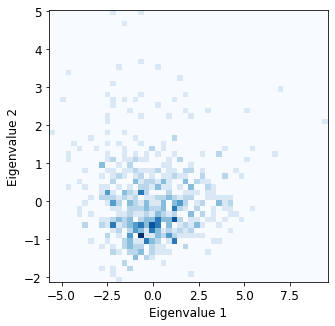

In [44]:
#labels_unique = np.unique(ms.labels_)
#n_clusters = len(labels_unique[labels_unique >= 0])

print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters)

# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X_reduced[:,0], X_reduced[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(ms.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

#scaler.fit(X_reduced)

H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('Eigenvalue 1')
ax.set_ylabel('Eigenvalue 2')

plt.show()